# 辺削除の挙動確認

In [18]:
import plotly.graph_objects as go
import networkx as nx
import pandas as pd

from matplotlib import pyplot as plt

In [19]:
#GRAPH_INPUT = '../s7_mini_seed7427.txt'
GRAPH_INPUT = '../s1_seed7552.txt'

with open(GRAPH_INPUT, 'r') as f:
    graph_def_str = f.readline().replace('\n', '')

In [20]:
graph_def = list(map(int, graph_def_str.split()))

In [21]:
N, M, D, K = graph_def[:4]
graph_def = graph_def[4:]

edge_info_list = {}
edge_list = []

for i in range(M):
    u = graph_def.pop(0)
    v = graph_def.pop(0)
    w = graph_def.pop(0)
    
    if u not in edge_info_list.keys():
        edge_info_list[u] = []
        
    if v not in edge_info_list.keys():
        edge_info_list[v] = []

    edge_info_list[u].append((i,v,w))
    edge_info_list[v].append((i,u,w))
    
    edge_list.append((u, v, w))

pos_list = {}

for i in range(N):
    u = i + 1
    x = graph_def.pop(0)
    y = graph_def.pop(0)
    
    pos_list[u] = (x, y)

In [22]:
G = nx.Graph()
G.add_weighted_edges_from(edge_list)

In [24]:
edge_info_list[421]

[(760, 47, 19416), (871, 373, 25612), (1069, 11, 15000)]

## 辺eを削除した時のコスト増加
* seed=7427だとe=786, cost=2,940,255が最大

In [84]:
e = 257
u, v, w = edge_list[e]
print('u={}, v={}, w={}'.format(u, v, w))

ux, uy = pos_list[u]
vx, vy = pos_list[v]
print('u=({}, {}), v=({}, {})'.format(ux, uy, vx, vy))

u=55, v=303, w=18000
u=(787, 892), v=(787, 874)


In [59]:
orig_all_path_cost = dict(nx.all_pairs_dijkstra_path_length(G))

del_G = G.copy()
del_G.remove_edge(u, v)

del_all_path_cost = dict(nx.all_pairs_dijkstra_path_length(del_G))

In [60]:
node_up_cost_list = []

for node in range(1, N+1):
    up_cost = sum(del_all_path_cost[node].values())
    up_cost -= sum(orig_all_path_cost[node].values())
    
    up_cost *= 1000
    up_cost /= N * (N-1)
    
    node_up_cost_list.append(up_cost)

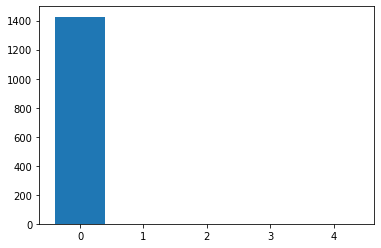

In [61]:
node_cost_up_df = pd.DataFrame()

node_cost_up_df['N'] = [i for i in range(1, N+1)]
node_cost_up_df['cost_up'] = node_up_cost_list

node_cost_up_df.sort_values('cost_up', ascending=False, inplace=True)

K= 5
plt.bar(range(K), node_cost_up_df[:K]['cost_up']);

In [62]:
node_cost_up_df[:K]

,N,cost_up
420,421,1426.878264
0,1,1.875004
513,514,1.875004
504,505,1.875004
505,506,1.875004


In [63]:
target_N = node_cost_up_df['N'].to_list()[0]
target_N

421

In [64]:
orig_shortest_path = nx.shortest_path(G, source=target_N, weight='weight')
del_shortest_path = nx.shortest_path(del_G, source=target_N, weight='weight')

In [65]:
orig_node_pair = set()
del_node_pair = set()

for node in range(1, N+1):
    for i in range(1, len(orig_shortest_path[node])):
        n1 = orig_shortest_path[node][i-1]
        n2 = orig_shortest_path[node][i]
        
        orig_node_pair.add((n1, n2))
        orig_node_pair.add((n2, n1))

    for i in range(1, len(del_shortest_path[node])):
        n1 = del_shortest_path[node][i-1]
        n2 = del_shortest_path[node][i]
        
        del_node_pair.add((n1, n2))
        del_node_pair.add((n2, n1))

In [66]:
node_list = set()

for node in range(1, N+1):
    if orig_shortest_path[node] ==  del_shortest_path[node]:
        continue
    
    orig_list = orig_shortest_path[node].copy()
    del_list = del_shortest_path[node].copy()
    
    while True:
        if len(orig_list) == 0 or len(del_list) == 0:
            break
        
        if orig_list[-1] != del_list[-1]:
            break
            
        orig_list.pop()
        del_list.pop()
    
    for n in orig_list:
        node_list.add(n)

    for n in del_list:
        node_list.add(n)

In [67]:
draw_node_list = set(node_list.copy())

for node in node_list:
    for i, to, w in edge_info_list[node]:
        draw_node_list.add(to)

In [68]:
fig = go.Figure()

# 幅を固定
fig.update_layout(
    width=750,
    height=750,
)

# 背景を白に変更
fig.update_layout(plot_bgcolor='white')    

grid_x = []
grid_y = []
    
for node in draw_node_list:
    x, y = pos_list[node]
    
    grid_x.append(x)
    grid_y.append(y)

label = list(map(str, draw_node_list))

fig.add_trace(
    go.Scatter(x=grid_x, y=grid_y, mode='markers+text', text=label, marker={'size': 6, 'color': '#333333'}, name='', textposition='top left')
)

drawed = set()

for node in draw_node_list:
    if node not in node_list:
        continue
        
    from_x, from_y = pos_list[node]

    for i, to, w in edge_info_list[node]:
        if (node, to) in drawed:
            continue
            
        to_x, to_y = pos_list[to]
        
        line_def = {'width': 2, 'color': '#333333'}
        
        if (node, to) in orig_node_pair and (node, to) in del_node_pair:
            # 最短路 -> 最短路
            line_def = {'width': 3, 'color': '#00d5ff'}

        if (node, to) in orig_node_pair and (node, to) not in del_node_pair:
            # 最短路 -> 非最短路
            line_def = {'width': 2, 'dash': 'dot', 'color': '#00d5ff'}

        if (node, to) not in orig_node_pair and (node, to) in del_node_pair:
            # 非最短路 -> 最短路
            line_def = {'width': 3, 'color': '#ec1818'}
        
        if (node == u and to == v) or (node == v and to == u):
            # 削除辺
            line_def = {'width': 3, 'dash': 'dot', 'color': '#ec1818'}
            
        fig.add_trace(
            go.Scatter(x=[from_x, to_x], y=[from_y, to_y], mode='lines', line=line_def, name='')
        )
        
        drawed.add((node, to))
        drawed.add((to, node))
        
fig.update_layout(showlegend=False)
fig.show()